In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

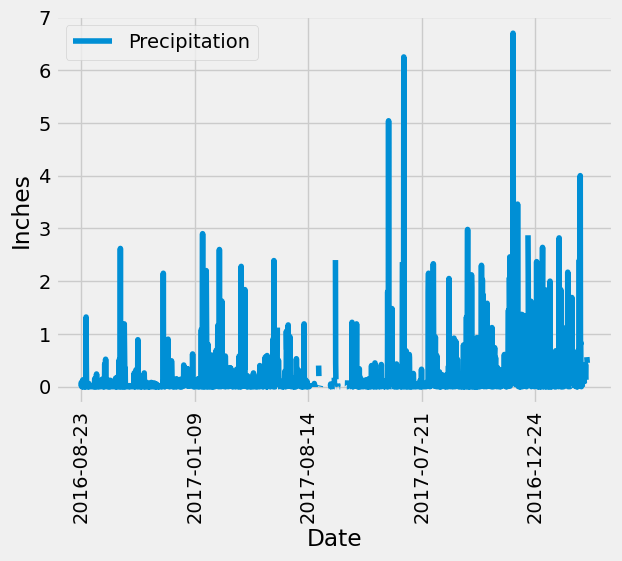

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

prior_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(prior_year)


# Perform a query to retrieve the data and precipitation scores

precip_query = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= prior_year).all()

#print(precip_query)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precip_data = [{"Date": result[0], "Precipitation": result[1]} for result in precip_query]

precip_df = pd.DataFrame(precip_data)

# Sort the dataframe by date

precip_df.sort_values(by=["Date"], ascending=True)
#print(precip_df)

# Use Pandas Plotting with Matplotlib to plot the data

x_label = "Date"
y_label = "Inches"
precip_df.plot(x="Date", y="Precipitation", xlabel=x_label, ylabel=y_label)
plt.xticks(rotation=90)
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

precip_mean = precip_df["Precipitation"].mean()
#print(precip_mean)
precip_median = precip_df["Precipitation"].median()
#print(precip_median)
precip_variance = precip_df["Precipitation"].var()
#print(precip_variance)
precip_stdev = precip_df["Precipitation"].std()
#print(precip_stdev)
precip_sem = precip_df["Precipitation"].sem()
#print(precip_sem)

precip_summary_stats = pd.DataFrame({
    "Mean Precipitation (inches)": precip_mean,
    "Median Precipitation (inches)": precip_median,
    "Precipitation Variance": precip_variance,
    "Precipitation St. Dev.": precip_stdev,
    "Precipitation Std. Err.": precip_sem
}, index=[0])

precip_summary_stats

,Mean Precipitation (inches),Median Precipitation (inches),Precipitation Variance,Precipitation St. Dev.,Precipitation Std. Err.
0,0.177279,0.02,0.212696,0.46119,0.010259


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset

columns = inspector.get_columns("Station")
for column in columns:
    print(column["name"], column["type"])

#session.query(Station.station).count()
total_stations = session.query(Measurement.station).distinct().count()

print(f"The total number of stations is {total_stations}.")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
The total number of stations is 9.


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# sel = [Measurement.station, Measurement.date, Measurement.prcp, func.sum(Measurement.tobs), Station.name, Station.latitude, Station.longitude, Station.elevation]

# measurement_station_combined = session.query(*sel).\
#     filter(Measurement.station == Station.station).group_by(Measurement.station).\
#         order_by(func.sum(Measurement.tobs).desc()).all()

# measurement_station_combined

#sel = [Measurement.station, Measurement.date, func.count(Measurement.prcp), Measurement.tobs, Station.name, Station.latitude, Station.longitude, Station.elevation]

measurement_station_combined = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

most_active_station = measurement_station_combined[0].station

print(f"The most active station is {most_active_station}.")

# for record in measurement_station_combined:
#     (measurement_station, station_name, measurement_count) = record
#     print(f"The station with the most observations is {station_name}, {measurement_station} with {measurement_count} observations.")



# print(f"{measurement_station_combined(Measurement.station[0])}")


The most active station is USC00519281.


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# min_temp = session.query(Measurement.station, Measurement.tobs).\
#     filter(Measurement.station == most_active_station).\
#     order_by(Measurement.tobs.asc()).all()
# min_temp

min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(min_temp)

max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(max_temp)

avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(avg_temp)

[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


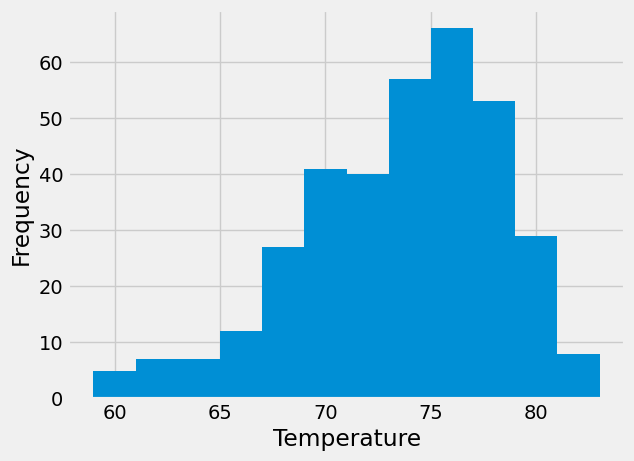

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelve_months_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= prior_year).all()\

twelve_months_temp_array = np.array(twelve_months_temp)

plt.hist(twelve_months_temp_array, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()